In [64]:
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
% matplotlib inline

from ssd import v2
from ssd.ssd import build_ssd
from lstm_model import RNNModel
from ssd.layers.modules import MultiBoxLoss
from torch.autograd import Variable

# from ssd.data import BaseTransform
from torch.utils.data import DataLoader
from torchvision import transforms, models
from visual_genome_loader import (VisualGenomeLoader,
                                  AnnotationTransform,
                                  ResizeTransform,
                                  detection_collate)


In [65]:
trainset = VisualGenomeLoader('../visual_genome',
                             transform=transforms.Compose([
                                 ResizeTransform((300, 300)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(
                                     mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])]),
                             target_transform=AnnotationTransform(),
                             top=150,
                             group=False)

with open('data/processed/corpus.pt', 'rb') as f:
    corpus = torch.load(f)
    
net = build_ssd('test', 300, 150)
net.eval()
with open('weights/ssd_lang.pt', 'rb') as f:
    state_dict = torch.load(f)
    net.load_state_dict(state_dict)
    
net.eval()
    
print('Loading RNN model...')
ntokens = len(corpus.dictionary)
lang_model = RNNModel('LSTM', ntokens, 200, 200,
                      2, 0.2, False)
lang_model.eval()

with open('model3.pt', 'rb') as f:
    state_dict = torch.load(f)
    lang_model.load_state_dict(state_dict)


Loading RNN model...


['a man wearing a tan sweater']

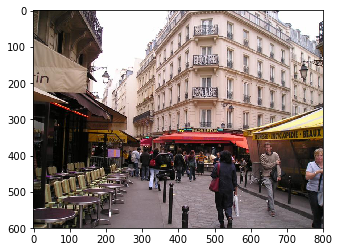

In [66]:
#img = Image.open('../visual_genome/VG_100K/2353025.jpg').convert('RGB')
img = cv2.cvtColor(trainset.pull_image(0), cv2.COLOR_BGR2RGB)
plt.imshow(img)

img = Image.fromarray(img)
transform = transforms.Compose([
      ResizeTransform((300, 300)),
      transforms.ToTensor(),
      transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225])])

x = transform(img)

img_arr = np.array(img).copy()
bbx, phrases = trainset.pull_anno(0)
phrases

In [67]:
phrase = 'a man wearing a tan sweater'
embedding = corpus.tokenize(phrase)

phrase_col = embedding.view(embedding.size(0), -1)
hidden = lang_model.init_hidden(phrase_col.size(1))
_, hidden = lang_model(Variable(phrase_col.cuda()), hidden)
hidden = [torch.stack(hidden, 0).view(-1, 1).data]
thought = torch.stack(hidden, 0)

x = torch.stack([x], 0)

In [68]:
detections = net((Variable(x.cuda()), Variable(thought))).data
scale = torch.Tensor([img_arr.shape[1], img_arr.shape[0],
                      img_arr.shape[1], img_arr.shape[0]])


frozenset({'shirt', 'man'}) 0.08019570261240005
(619.44824, 375.91193, 683.12415, 471.37152)
frozenset({'shorts', 'man'}) 0.0887831300497055
(487.46405, 474.18893, 557.21771, 538.38947)
frozenset({'leg', 'person'}) 0.0809817984700203
(637.46173, 448.63104, 683.83521, 553.14301)


[[618, 360, 695, 581]]

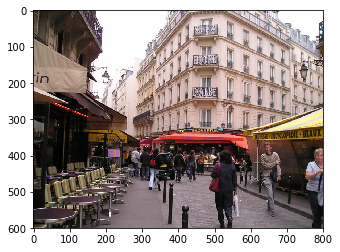

In [69]:
for i in range(detections.size(1)):
    j = 0
    #print(detections[0, i, j, 0])
    while detections[0, i, j, 0] >= 0.08:
        score = detections[0, i, j, 0]
        label_name = trainset.idx_obj[i]
        print(label_name, score)
        pt = (detections[0, i, j, 1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1], pt[2], pt[3])
        print(coords)
        #pred_num += 1
        j += 1
        
cv2.rectangle(img_arr, (619, 376), (683, 471), (0, 255, 0), 1)
#cv2.rectangle(img_arr, (487, 474), (557, 538), (255, 0, 0), 1)
plt.imshow(img_arr)

bbx

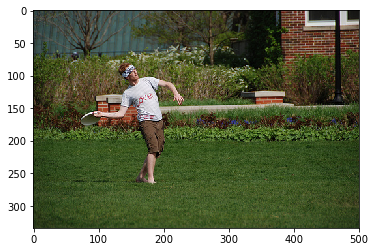

In [70]:
img = Image.open('../visual_genome/VG_100K/2353025.jpg').convert('RGB')
#img = Image.fromarray(img)
plt.imshow(img)
transform = transforms.Compose([
      ResizeTransform((300, 300)),
      transforms.ToTensor(),
      transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225])])

x = transform(img)
img_arr = np.array(img).copy()

In [71]:
phrase = 'man throwing frisbee'
embedding = corpus.tokenize(phrase)

phrase_col = embedding.view(embedding.size(0), -1)
hidden = lang_model.init_hidden(phrase_col.size(1))
_, hidden = lang_model(Variable(phrase_col.cuda()), hidden)
hidden = [torch.stack(hidden, 0).view(-1, 1).data]
thought = torch.stack(hidden, 0)

x = torch.stack([x], 0)

In [72]:
detections = net((Variable(x.cuda()), Variable(thought))).data
scale = torch.Tensor([img_arr.shape[1], img_arr.shape[0],
                      img_arr.shape[1], img_arr.shape[0]])


frozenset({'shorts', 'man'})
(158.57162, 165.59334, 205.42551, 205.13341) 0.1492968201637268
frozenset({'shorts', 'man'})
(164.23138, 188.92116, 204.28236, 224.6115) 0.08666964620351791
frozenset({'shorts', 'man'})
(153.73611, 133.69934, 201.64635, 170.87883) 0.08182752132415771


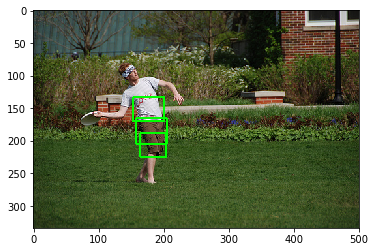

In [73]:
bboxes = []
for i in range(detections.size(1)):
    j = 0
    #print(detections[0, i, j, 0])
    while detections[0, i, j, 0] >= 0.08:
        score = detections[0, i, j, 0]
        label_name = trainset.idx_obj[i]
        print(label_name)
        pt = (detections[0, i, j, 1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1], pt[2], pt[3])
        print(coords, score)
        bboxes.append(coords)
        #pred_num += 1
        j += 1
        
for b in bboxes:
    cv2.rectangle(img_arr, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)

plt.imshow(img_arr)

['THE BOY IS WEARING BLUE PANTS']

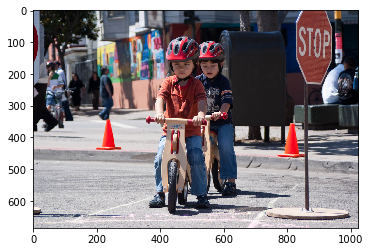

In [74]:
img = cv2.cvtColor(trainset.pull_image(1), cv2.COLOR_BGR2RGB)
plt.imshow(img)

img = Image.fromarray(img)
transform = transforms.Compose([
      ResizeTransform((300, 300)),
      transforms.ToTensor(),
      transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225])])

x = transform(img)

img_arr = np.array(img).copy()
bbx, phrases = trainset.pull_anno(1)
phrases

In [75]:
phrase = 'THE BOY IS WEARING BLUE PANTS'
embedding = corpus.tokenize(phrase)

phrase_col = embedding.view(embedding.size(0), -1)
hidden = lang_model.init_hidden(phrase_col.size(1))
_, hidden = lang_model(Variable(phrase_col.cuda()), hidden)
hidden = [torch.stack(hidden, 0).view(-1, 1).data]
thought = torch.stack(hidden, 0)

x = torch.stack([x], 0)

In [76]:
detections = net((Variable(x.cuda()), Variable(thought))).data
scale = torch.Tensor([img_arr.shape[1], img_arr.shape[0],
                      img_arr.shape[1], img_arr.shape[0]])

frozenset({'person'})
(94.766846, 17.475794, 152.73308, 117.13482) 0.08613255620002747
frozenset({'man', 'hat'})
(499.36462, 98.807304, 610.58508, 170.57994) 0.08782396465539932
frozenset({'leg', 'person'})
(599.89044, 393.53116, 661.15625, 500.19769) 0.09787989407777786
frozenset({'outdoors', 'people'})
(24.127319, 390.99844, 458.37875, 575.96423) 0.08046307414770126


[[377, 356, 558, 600]]

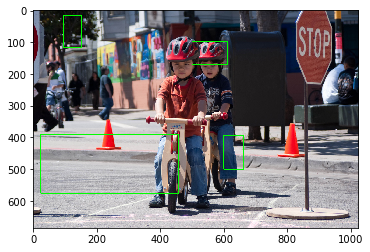

In [77]:
bboxes = []
for i in range(detections.size(1)):
    j = 0
    #print(detections[0, i, j, 0])
    while detections[0, i, j, 0] >= 0.08:
        score = detections[0, i, j, 0]
        label_name = trainset.idx_obj[i]
        print(label_name)
        pt = (detections[0, i, j, 1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1], pt[2], pt[3])
        print(coords, score)
        bboxes.append(coords)
        #pred_num += 1
        j += 1

for b in bboxes:
    cv2.rectangle(img_arr, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)

plt.imshow(img_arr)
bbx